<h3>Set Up Your Environment</h3>

In [29]:
!pip install pandas scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


<h3>Load and Explore the Dataset</h3>

In [53]:
import pandas as pd

#dataset of 1000 records about customer segments
df = pd.read_csv('s3://knodax-business-problems-as-ml-problems/customer_segments_dataset.csv')  # Replace with your S3 path or local path

print(df.head())



   Unnamed: 0  CustomerID  Age  Annual_Income  Spending_Score Segment
0           0        1001   22          25000              77       A
1           1        1002   35          48000              52       B
2           2        1003   40          61000              59       B
3           3        1004   23          27000              80       A
4           4        1005   31          53000              47       B


Column Explanation:<br>
<li>CustomerID: Unique identifier for each customer.</li>
<li>Age: Age of the customer.</li>
<li>Annual_Income: Customer's income in USD.</li>
<li>Spending_Score: Score assigned based on purchase behavior.</li>
<li>Segment: Label for supervised learning (for classification); can be ignored during unsupervised clustering.</li>


In [55]:
# Clean the data: drop "Unnamed: 0" column
df = df.drop(df.columns[0], axis=1)
print(df.head())

   Age  Annual_Income  Spending_Score Segment
0   22          25000              77       A
1   35          48000              52       B
2   40          61000              59       B
3   23          27000              80       A
4   31          53000              47       B


<h3>Rename 'Segment' column to 'Target'</h3>

In [57]:
# Rename 'Segment' to 'Target' because we will be this column as a label (target)
df = df.rename(columns={'Segment': 'Target'})
print(df.head())

   Age  Annual_Income  Spending_Score Target
0   22          25000              77      A
1   35          48000              52      B
2   40          61000              59      B
3   23          27000              80      A
4   31          53000              47      B


<h3>Build Train and Test Dataset. Separate the dataset into 80% train and 20% test data.</h3>

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("***X_train***")
print(X_train)
print("***X_test***")
print(X_test)
print("***y_train***")
print(y_train)
print("***y_test***")
print(y_test)


***X_train***
     Age  Annual_Income  Spending_Score
29    48          68000              33
535   45          55537              68
695   54          27536              57
557   47          79191              70
836   43          40360              85
..   ...            ...             ...
106   27          46579              90
270   60          42565              27
860   20          66649              95
435   30          45838              80
102   49          48545              21

[800 rows x 3 columns]
***X_test***
     Age  Annual_Income  Spending_Score
521   46          57838              27
737   35          77321              95
740   18          32054              86
660   56          58760              85
411   27          68135              22
..   ...            ...             ...
408   53          73404              64
332   28          52828              27
208   59          32565              95
613   42          45465              32
78    21          51734      

<h3>Build a Supervised Classification Model (e.g., Logistic Regression)</h3>

In [59]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Accuracy:", accuracy_score(y_test, y_pred))

Classification Accuracy: 0.665


It means the model correctly predicted the outcome 66.5% of the time. In other words, about two out of every three predictions were correct.

<h3>Build an Unsupervised Clustering Model (e.g., KMeans)</h3>
Use the same input features but ignore the labels during training.

In [66]:
from sklearn.cluster import KMeans
import pandas as pd

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
numeric_clusters = kmeans.fit_predict(X)

# Map numeric labels to 'A', 'B', 'C'
label_map = {0: 'A', 1: 'B', 2: 'C'}
clusters = pd.Series(numeric_clusters).map(label_map)

# Add to DataFrame if needed
df["Cluster"] = clusters
print(df.head())



   Age  Annual_Income  Spending_Score Target Cluster_Label Cluster
0   22          25000              77      A             C       C
1   35          48000              52      B             A       A
2   40          61000              59      B             B       B
3   23          27000              80      A             C       C
4   31          53000              47      B             A       A


<h3>Compare Results from Supervised and Unsupervised Models</h3>
Compare predicted clusters with true labels to observe alignment or discrepancy. You can visualize the result using seaborn pairplots or confusion matrices:

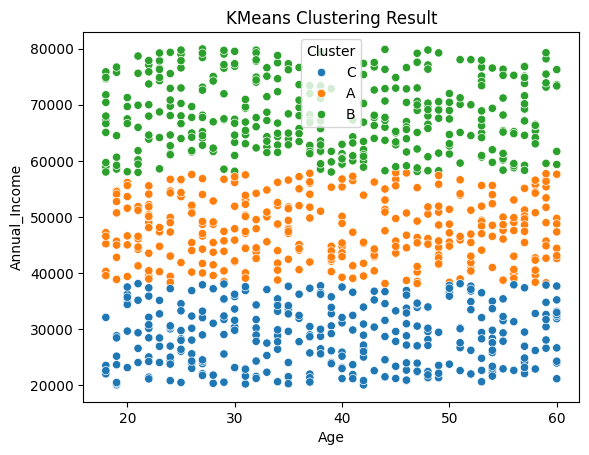

Confusion Matrix:
 [[  0   0 108]
 [101 104  92]
 [224 255 116]]


In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df['Cluster'])
plt.title("KMeans Clustering Result")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(df['Target'], df['Cluster']))



The confusion matrix compares the true labels (df['Target']) with the cluster labels predicted by KMeans (df['Cluster']). Since KMeans is unsupervised, it assigns cluster numbers arbitrarily — it doesn't know the actual class names. The confusion matrix shows how those arbitrary clusters align with the true categories.

In this case:
<li>The first row (true label = A) has all 108 samples incorrectly classified into cluster C — none were predicted correctly.</li>
<li>The second row (true label = B) has a mix of predictions: 101 to cluster A, 104 to cluster B (correct), and 92 to cluster C.</li>
<li>The third row (true label = C) is also scattered: 224 to cluster A, 255 to cluster B, and only 116 correctly to cluster C.</li>
<br>
Interpretation in brief:
There’s a mismatch between true labels and KMeans cluster IDs. This is normal in unsupervised learning — to better understand the alignment, you'd need to map clusters to the closest matching true labels using majority voting or label alignment.

### Model Comparison: Logistic Regression vs KMeans Clustering

In terms of analysis, **Logistic Regression** is clearly performing better than **KMeans** for this classification task. Here's a brief breakdown:

---

#### 1. Logistic Regression (Supervised Learning)
- **Classification Accuracy:** `0.665` → 66.5% of predictions are correct.
- Logistic Regression is a **supervised** algorithm — it uses the true target labels during training to learn patterns.
- Since it has access to labeled data, it's expected to perform better when labels are available.

---

#### 2. KMeans Clustering (Unsupervised Learning)
**Confusion Matrix:**


[[ 0 0 108]<br>
[101 104 92]<br>
[224 255 116]]<br>

- KMeans is **unsupervised**, meaning it does **not** use target labels during training.
- It groups data based on similarity (distance), not on known classes.
- The confusion matrix shows **severe misalignment**:
  - All class 0 samples were incorrectly grouped into another cluster.
  - Class 2 samples are heavily scattered across multiple clusters.

---

### Conclusion:
- **Logistic Regression** is more effective in this case because it leverages label information and achieves decent accuracy.
- **KMeans** is not reliable for classification here, as it doesn't align well with the true class structure.

> Use **Logistic Regression** (or other supervised models) when target labels are available.
> Use **KMeans** when exploring structure in **unlabeled** data.
